In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 3)

In [3]:
import numpy as np
import tqdm
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import pandas as pd

In [4]:
from utils import read_timeseries,generate_sequence, plt_lmbda
from module import GTPP
from run import get_parser

In [5]:
parser = get_parser()
argv = """
--epochs=100
""".replace('\n', '').split()
config = parser.parse_args(argv)
config

Namespace(alpha=0.05, batch_size=128, data='exponential_hawkes', dropout=0.1, emb_dim=10, epochs=100.0, event_class=1, hid_dim=64, log_mode=False, log_t=False, lr=0.001, mean_first=False, mlp_dim=64, mlp_layer=2, prt_evry=15, seq_len=20)

# Data

In [6]:

path = 'data/'

if config.data == 'exponential_hawkes':

    train_data = read_timeseries(path + config.data + '_training.csv')
    val_data = read_timeseries(path + config.data + '_validation.csv')
    test_data = read_timeseries(path + config.data + '_testing.csv')
else:
    raise NotImplemented('only exponential_hawkes')


train_timeseq, train_eventseq = generate_sequence(train_data, config.seq_len, log_mode=config.log_mode)
train_loader = DataLoader(torch.utils.data.TensorDataset(train_timeseq, train_eventseq), shuffle=True, batch_size=config.batch_size)

val_timeseq, val_eventseq = generate_sequence(val_data, config.seq_len, log_mode=config.log_mode)
val_loader = DataLoader(torch.utils.data.TensorDataset(val_timeseq, val_eventseq), shuffle=False, batch_size=len(val_data))


# Model

In [7]:
import torch.optim

In [8]:
import pytorch_lightning as pl

class CryptoTraderNPP(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self._model = GTPP(config)

    def forward(self, x):
        return self._model(x)

    def training_step(self, batch, batch_idx, phase='train'):
        torch.set_grad_enabled(True) # we need grad event in val and test
        
        loss, log_lmbda, int_lmbda, lmbda = self._model(batch)
        
        if phase!='train':
            # free the graph, free mem
            loss = loss.detach()

        # record weights
        self.log_dict({
            f'loss/{phase}': loss,
        }, prog_bar=True)

        assert torch.isfinite(loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx, phase='val')
    
    def predict_step(self, batch, batch_idx):
        y_pred = self.forward(batch)
        # on predict we want to return multiple values, not just the loss
        return (y_pred, *batch)
    
    def on_phase_end(self) -> None:
        # this seems to help with cuda memory
        self._model.zero_grad()
        torch.cuda.empty_cache()
        
    def on_train_end(self):
        self.on_phase_end()
        
    def on_validation_end(self):
        self.on_phase_end()
        
    def on_predict_end(self):
        self.on_phase_end()
        
    def on_epoch_end(self):
        if self.trainer.current_epoch%5==0:
            i=0
            device = self.device
            self.eval().cpu()
            plt.title(f'train {i} e={self.trainer.current_epoch}')
            plt_lmbda(train_data[i], model=self, seq_len=config.seq_len, log_mode=config.log_mode)
            plt.show()

            plt.title(f'val {i} e={self.trainer.current_epoch}')
            plt_lmbda(val_data[i], model=self, seq_len=config.seq_len, log_mode=config.log_mode)
            plt.show()

            model.to(device).train()

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=config.lr)
        return {'optimizer': optim, 'monitor': 'loss/val'}

In [9]:
model = CryptoTraderNPP(config)
model

CryptoTraderNPP(
  (_model): GTPP(
    (embedding): Embedding(1, 10)
    (emb_drop): Dropout(p=0.1, inplace=False)
    (lstm): LSTM(11, 64, batch_first=True)
    (intensity_net): IntensityNet(
      (linear1): Linear(in_features=1, out_features=1, bias=True)
      (linear2): Linear(in_features=65, out_features=64, bias=True)
      (module_list): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=True)
      )
      (linear3): Sequential(
        (0): Linear(in_features=64, out_features=1, bias=True)
        (1): Softplus(beta=1, threshold=20)
      )
    )
  )
)

# Train

In [10]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

In [11]:
trainer = pl.Trainer(
    max_epochs=config.epochs,
    gpus=1,
    logger=[
        CSVLogger('../outputs/logs')
    ],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type | Params
--------------------------------
0 | _model | GTPP | 28.2 K
--------------------------------
28.2 K    Trainable params
0         Non-trainable params
28.2 K    Total params
0.113     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/wassname/miniforge3/envs/cryptotrader/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


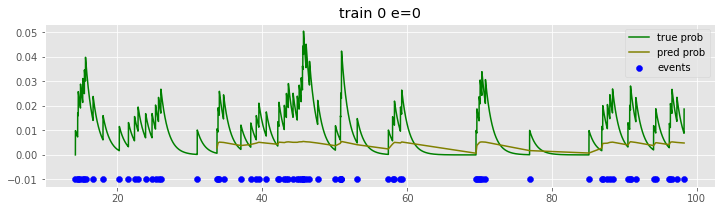

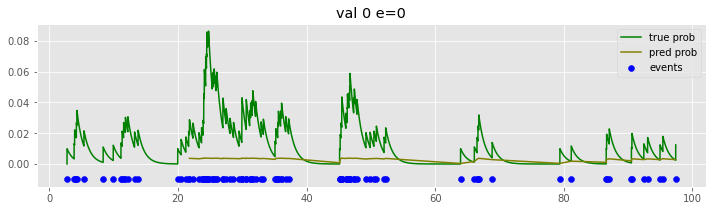

/home/wassname/miniforge3/envs/cryptotrader/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

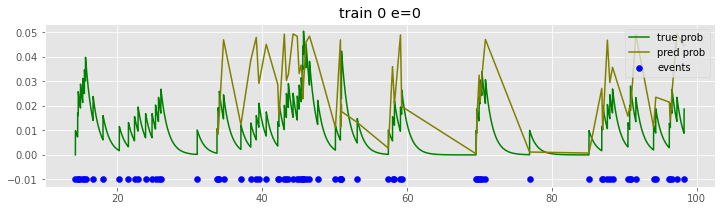

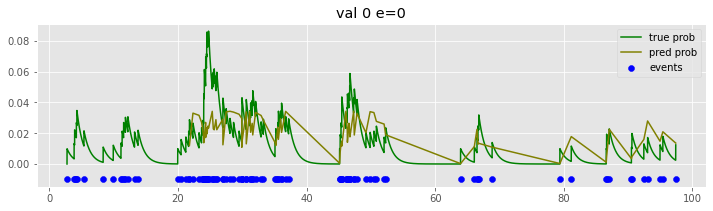

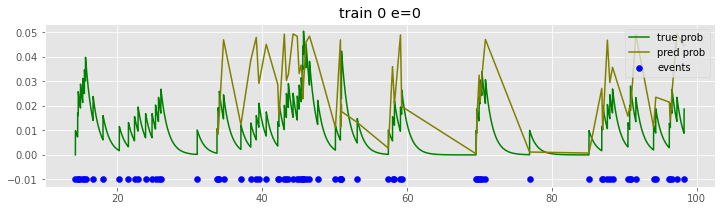

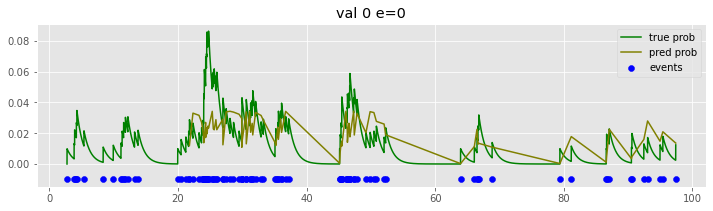

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

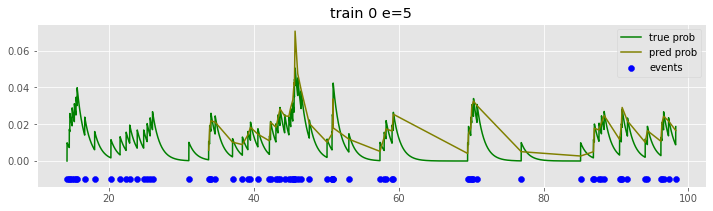

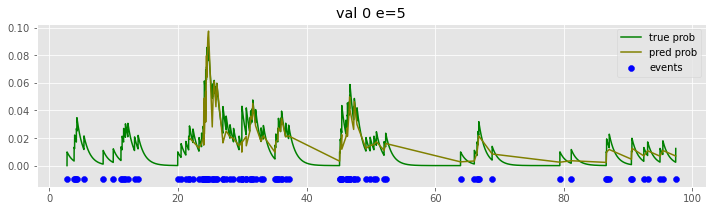

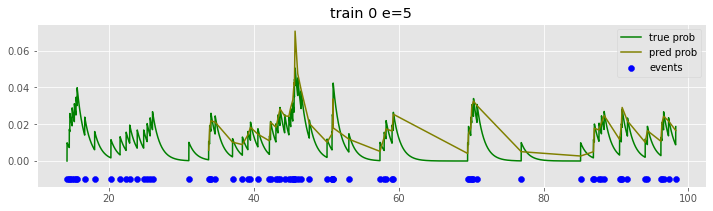

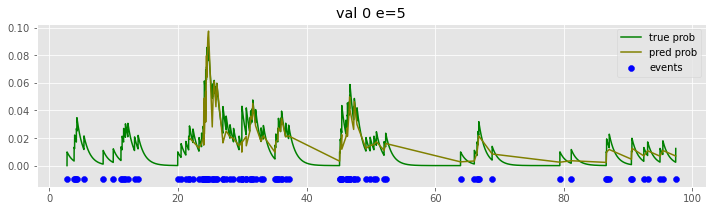

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

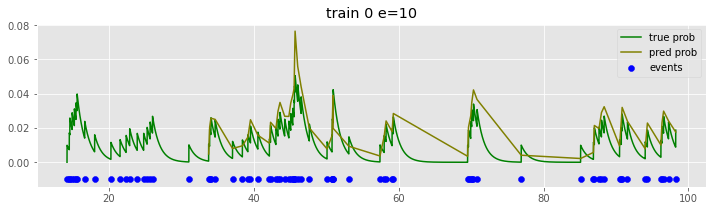

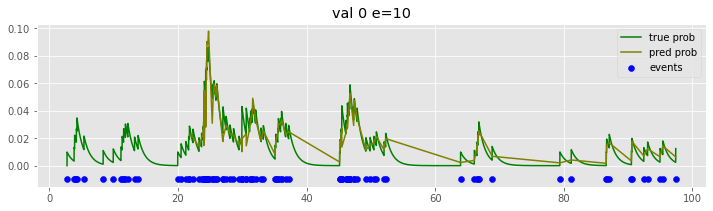

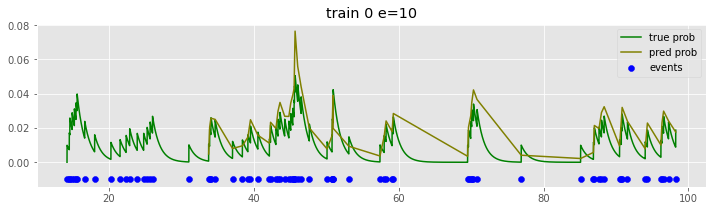

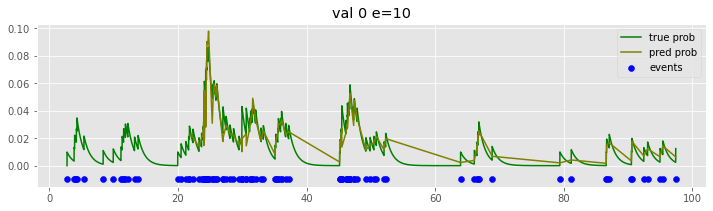

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

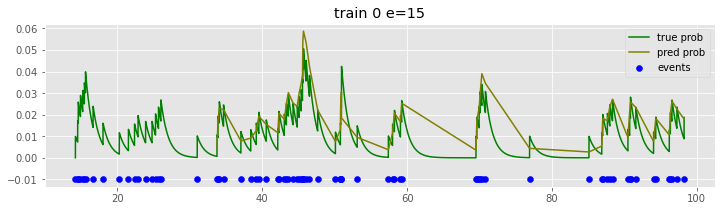

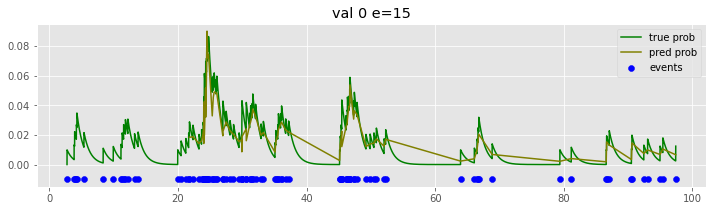

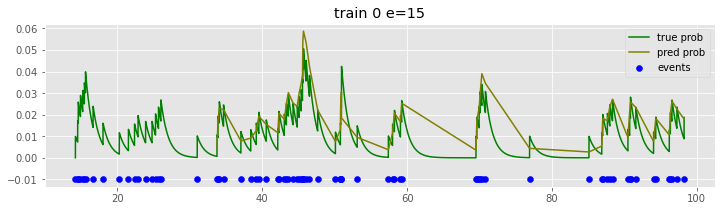

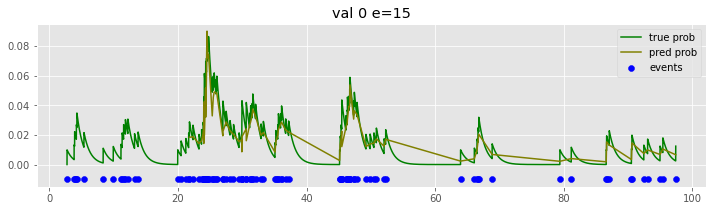

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

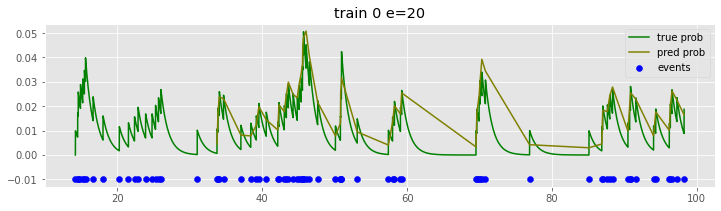

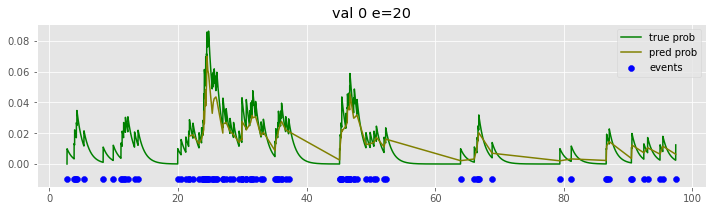

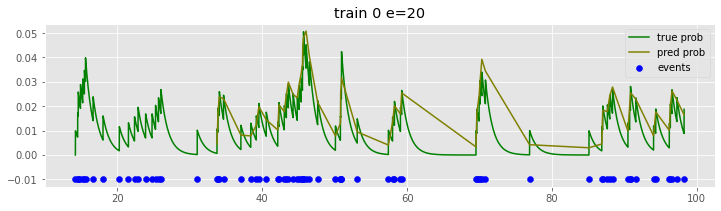

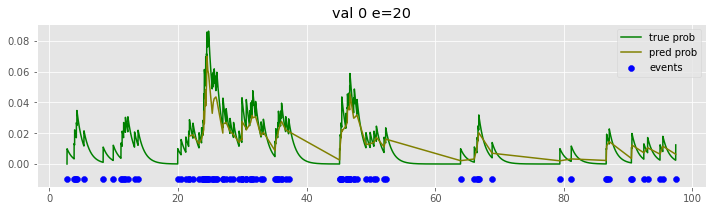

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

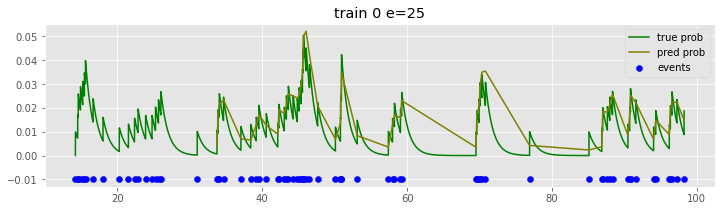

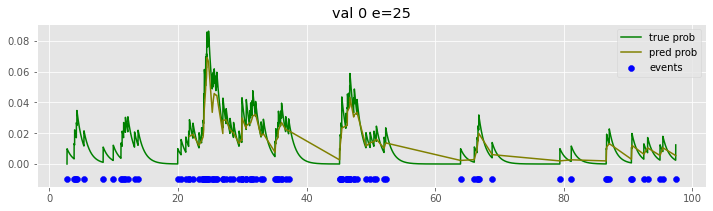

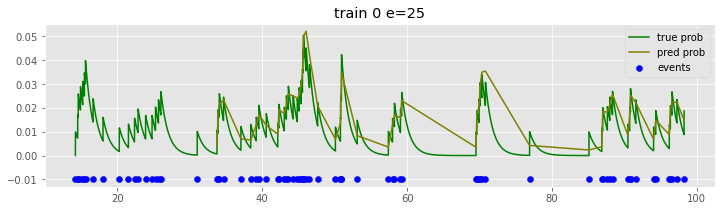

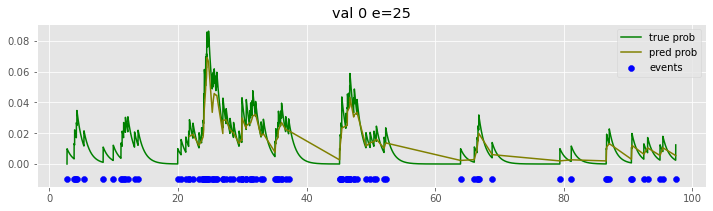

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

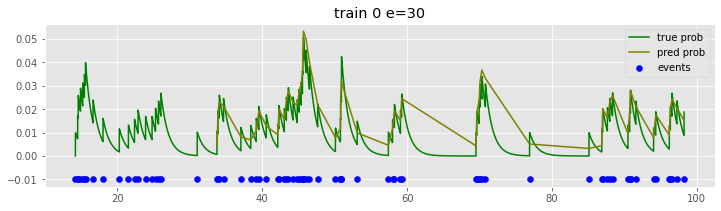

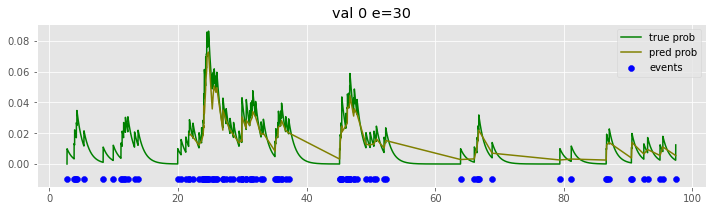

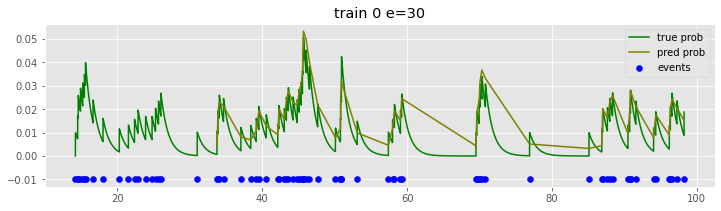

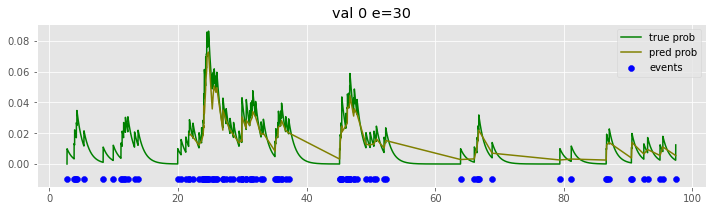

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

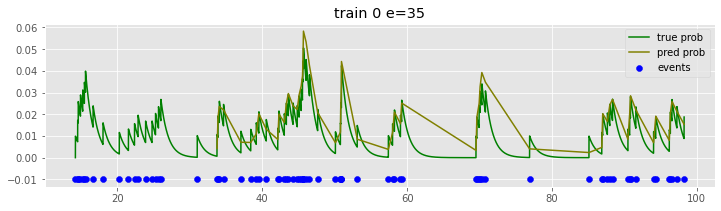

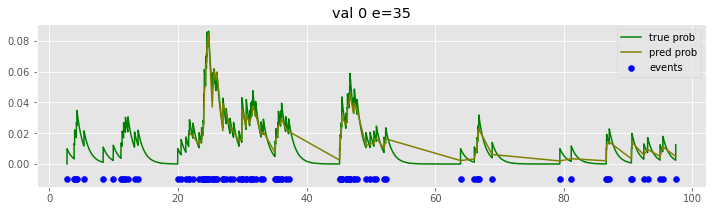

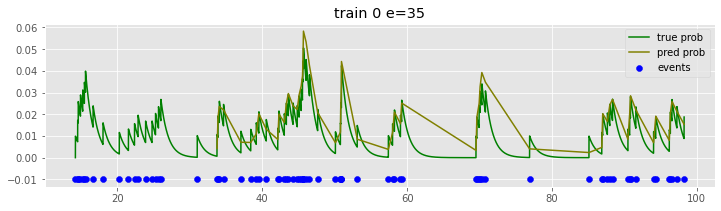

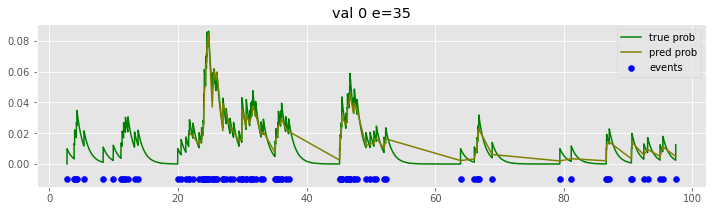

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

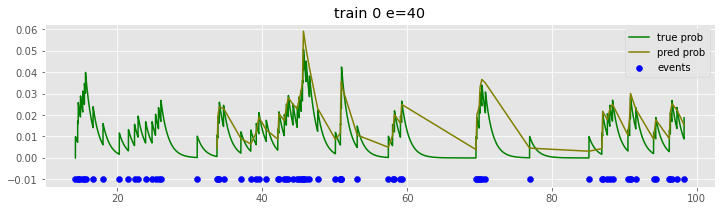

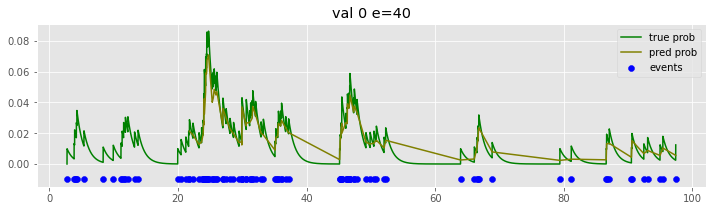

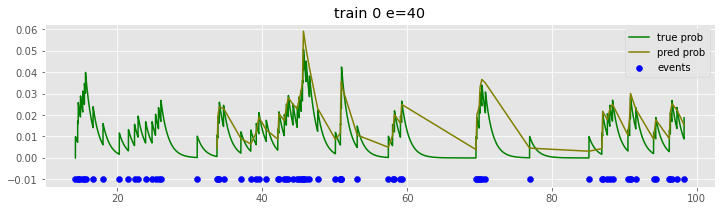

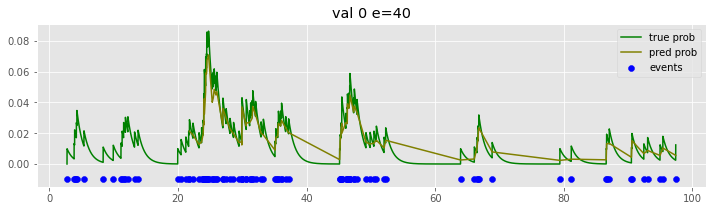

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

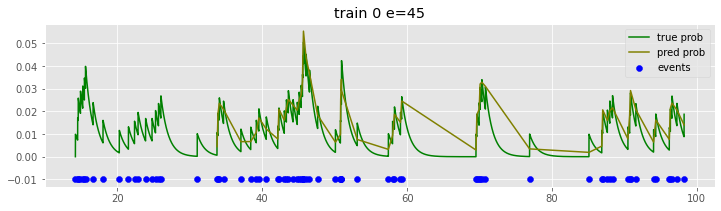

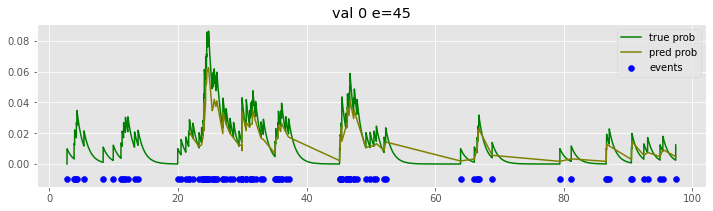

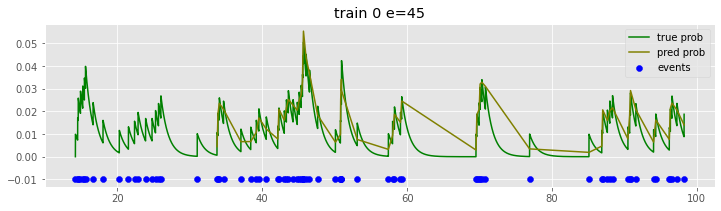

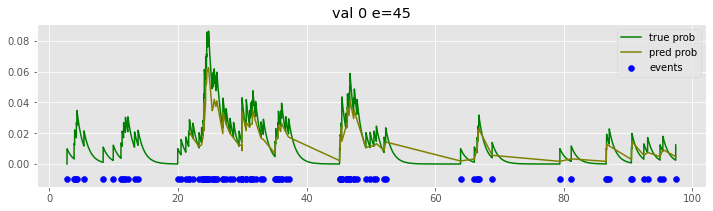

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

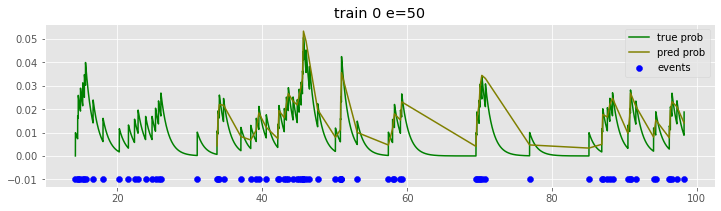

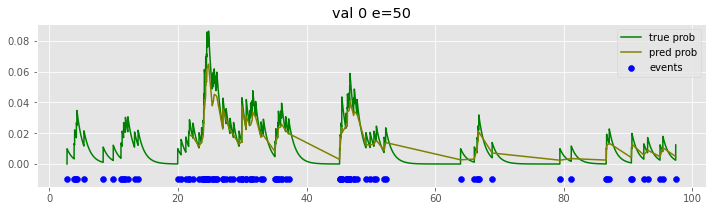

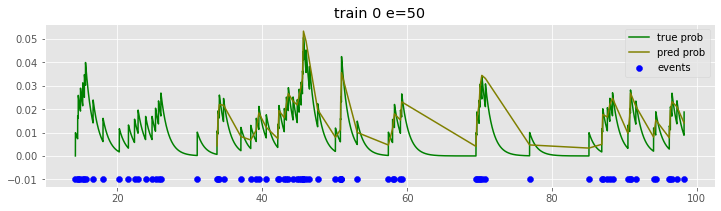

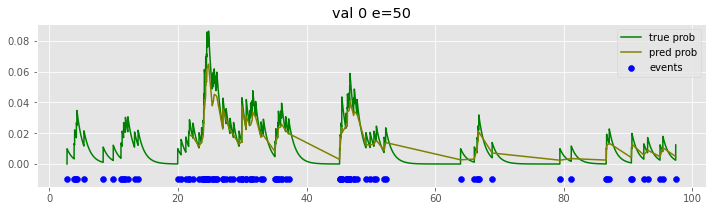

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

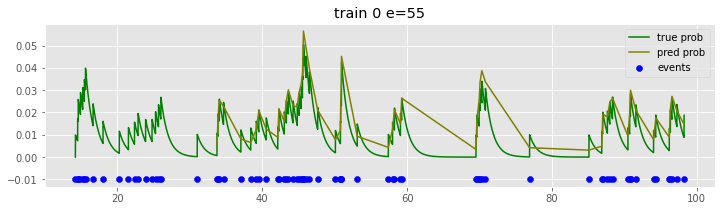

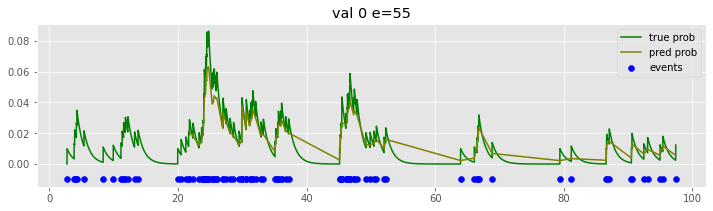

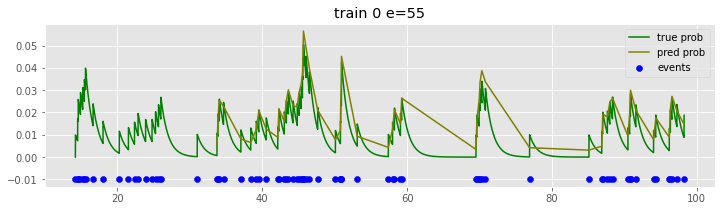

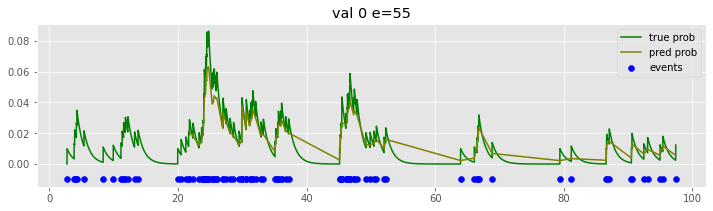

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

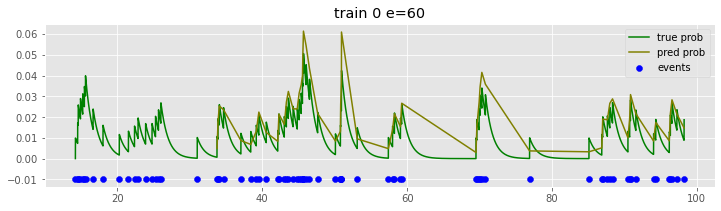

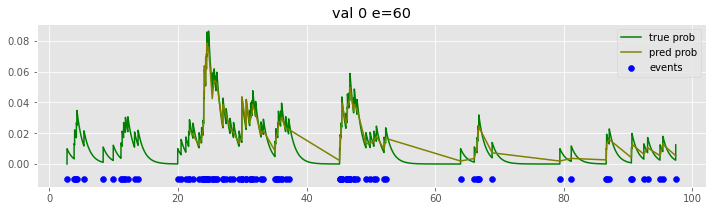

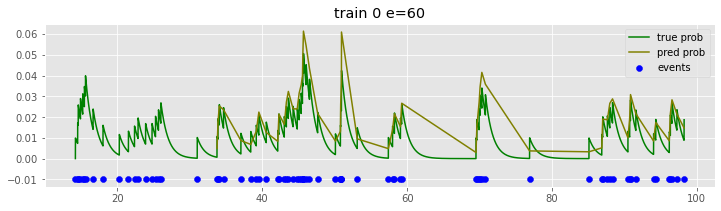

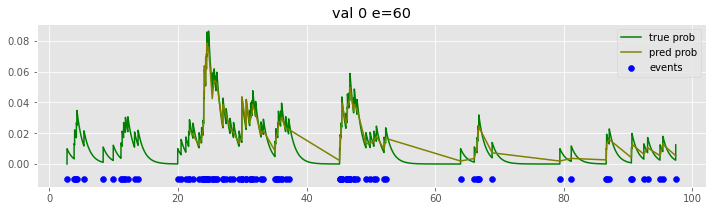

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

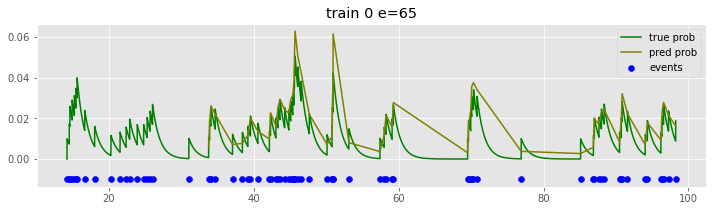

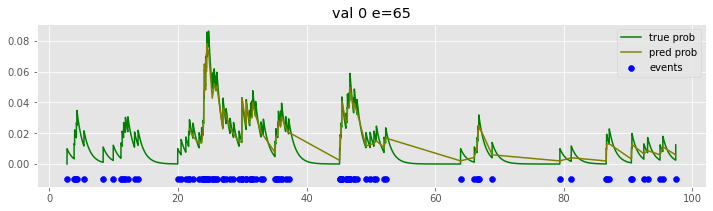

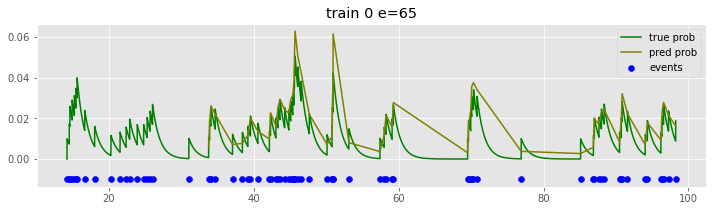

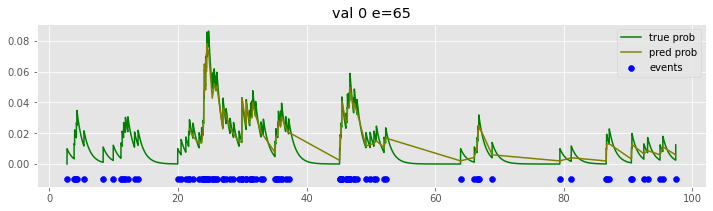

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

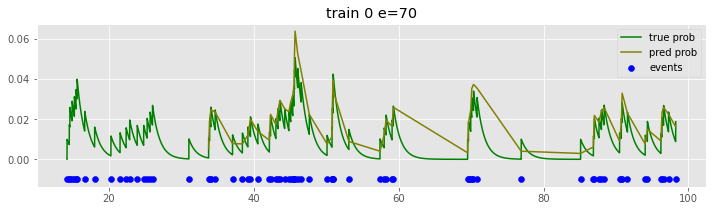

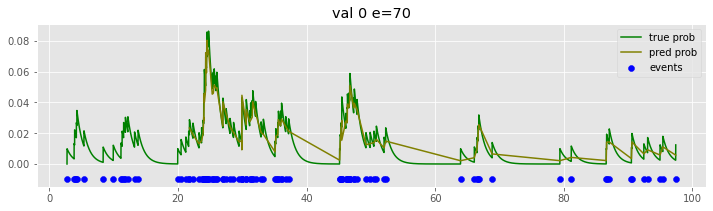

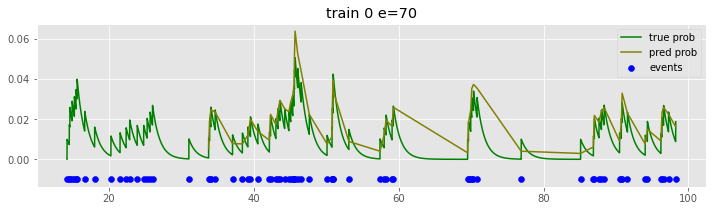

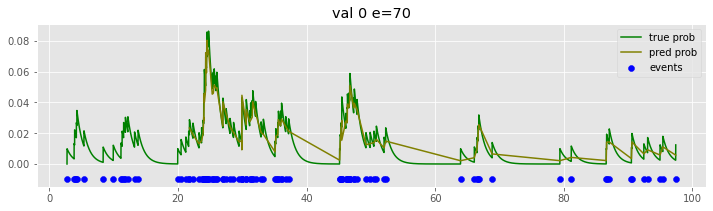

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

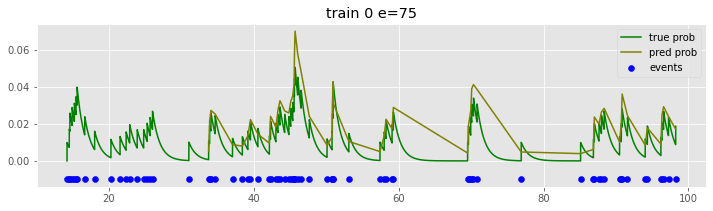

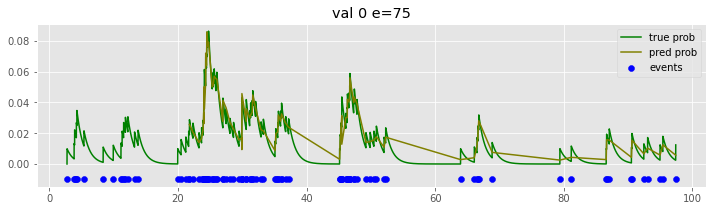

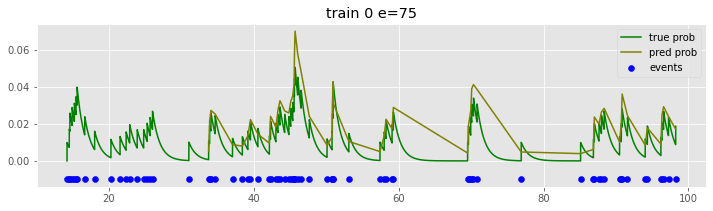

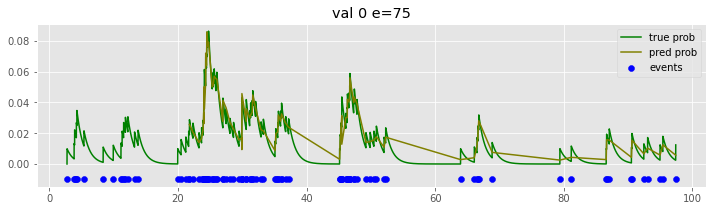

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

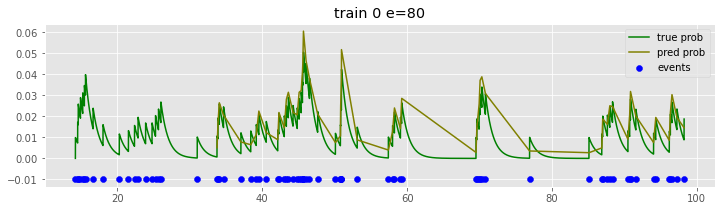

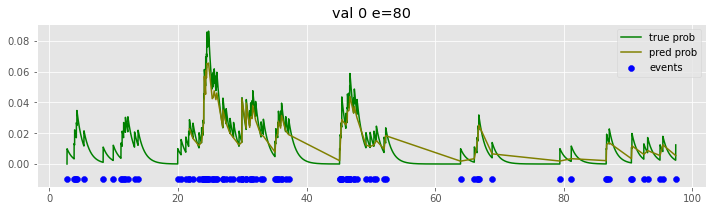

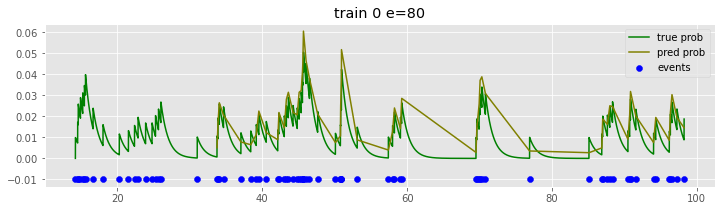

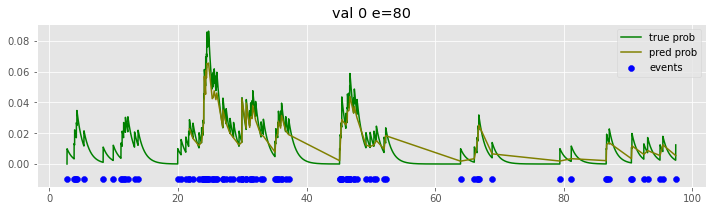

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

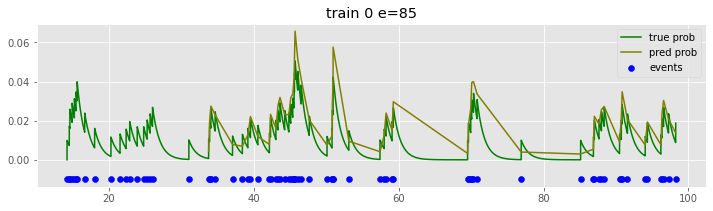

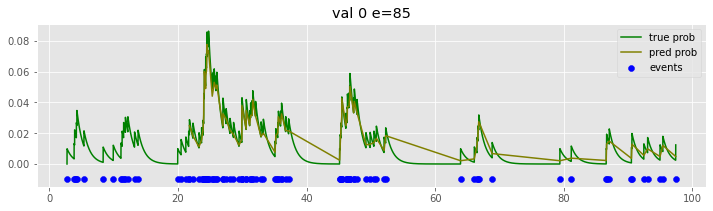

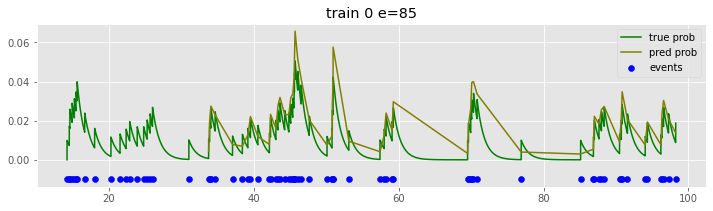

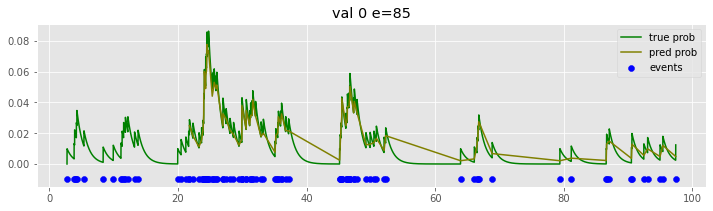

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

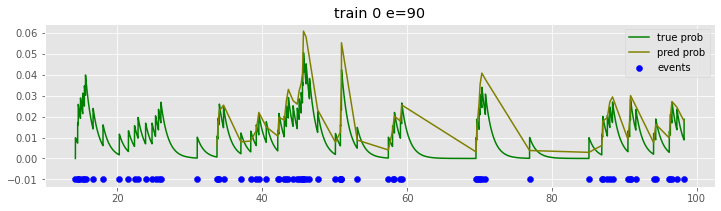

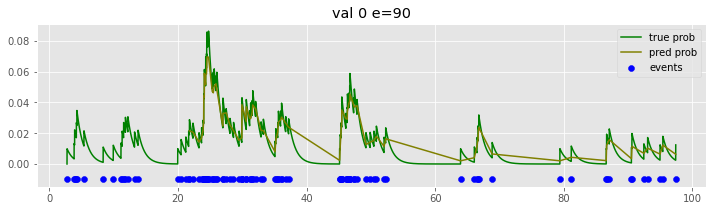

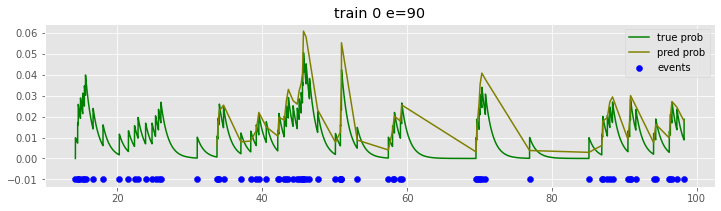

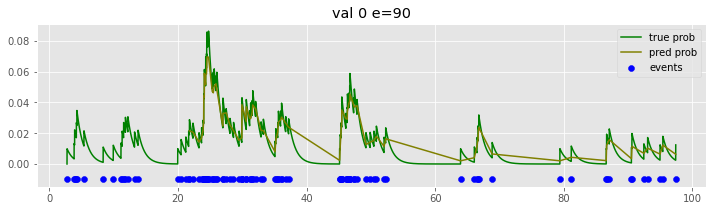

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

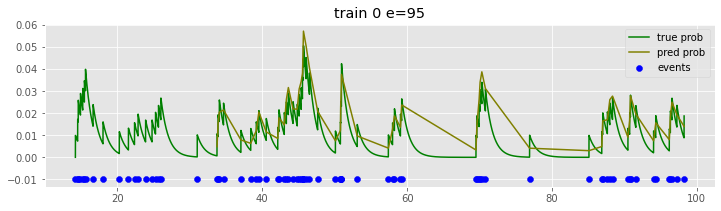

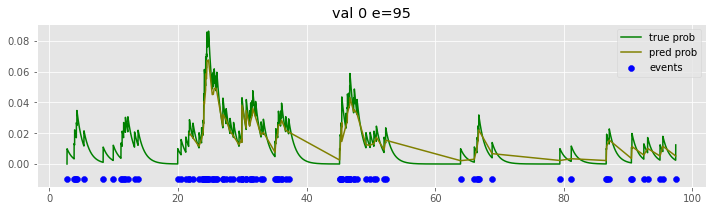

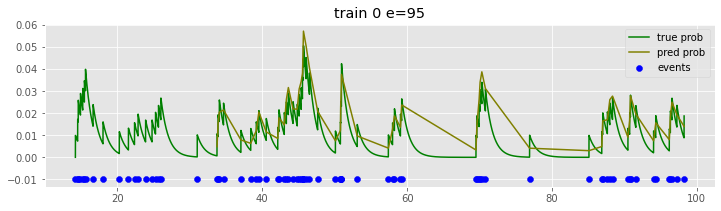

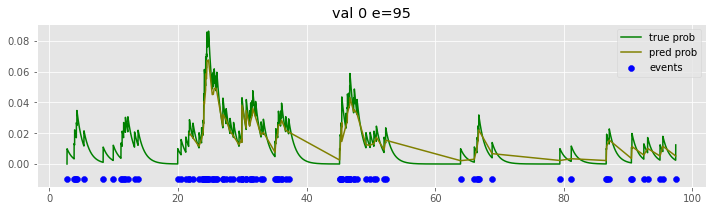

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [12]:
trainer.fit(model, train_loader, val_loader)

# Hist

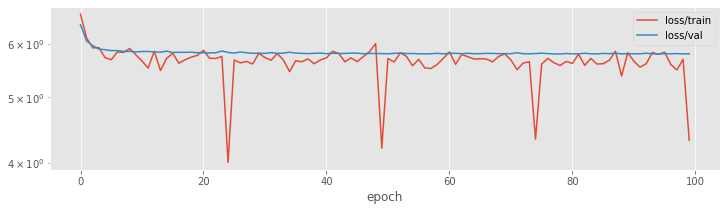

<AxesSubplot:xlabel='epoch'>

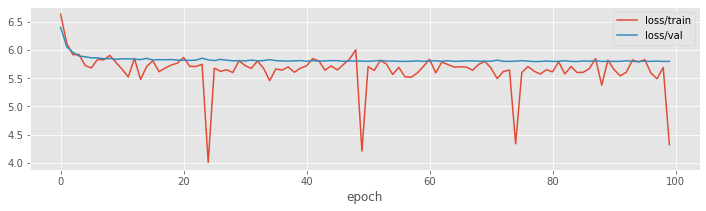

In [13]:
csv_logger = trainer.logger[0]
hp = Path(csv_logger.experiment.metrics_file_path)
df = pd.read_csv(hp).groupby('epoch').min()[['loss/train', 'loss/val']]
df.plot(logy=True)
plt.show()
df.plot()

# Plot

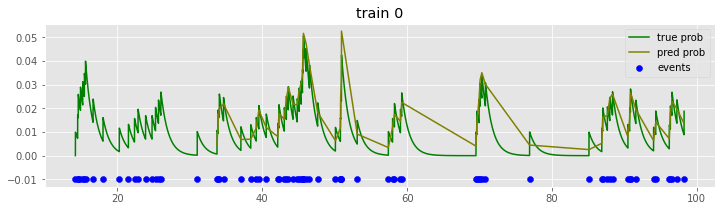

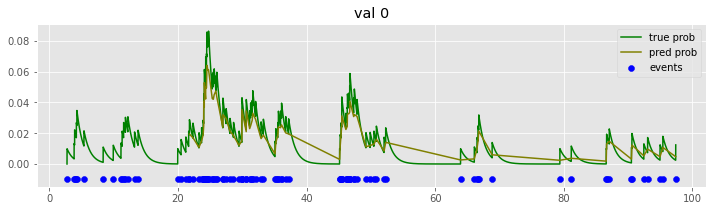

In [14]:
i=0

plt.title(f'train {i}')
plt_lmbda(train_data[i], model=model, seq_len=config.seq_len, log_mode=config.log_mode)
plt.show()

plt.title(f'val {i}')
plt_lmbda(val_data[i], model=model, seq_len=config.seq_len, log_mode=config.log_mode)
plt.show()

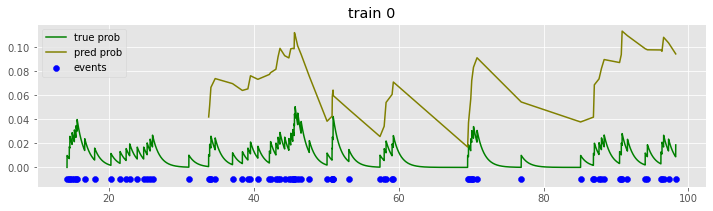

In [15]:
plt.title(f'train {i}')
plt_lmbda(train_data[i], model=model, seq_len=config.seq_len, log_mode=~config.log_mode)
plt.show()

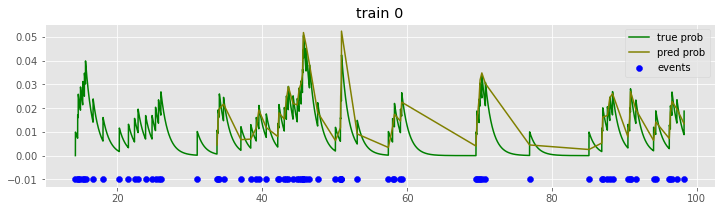

In [16]:
plt.title(f'train {i}')
plt_lmbda(train_data[i], model=model, alpha=0.01, lmbda0=0, seq_len=config.seq_len, log_mode=config.log_mode)
plt.show()